In [24]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import math

In [25]:

# 1. 加载数据
def load_dataset(path):
    """加载数据集并提取所需信息"""
    data = pd.read_csv(path, header=3)
    timestamp = data.iloc[:, 0].to_numpy()  # 时间戳
    output_voltage = data.iloc[:, 1].to_numpy()
    output_current = data.iloc[:, 2].to_numpy()
    thermistor_temperatures = data.iloc[:, 3:].to_numpy()  # 8个温度传感器数据
    
    return timestamp, output_voltage, output_current, thermistor_temperatures

In [26]:
# 2. 计算传感器位置（单位：cm，转换为与L相同的单位）
def calculate_positions():
    """计算8个温度传感器的位置坐标"""
    L = 0.041  
    bottom_distance = 0.003  
    spacing = 0.005  
    
    positions = []
    for i in range(8):
        pos = bottom_distance + i * spacing
        positions.append(pos)
    
    return np.array(positions)

In [27]:
calculate_positions()

array([0.003, 0.008, 0.013, 0.018, 0.023, 0.028, 0.033, 0.038])

In [28]:
def temperature_model(t, D, C_minus, T0, omega, x):
    """
    根据给定的热流模型计算温度（加入T0作为温度中心线参数）
    参数：
    t: 时间
    D: 扩散系数（待求）
    C_minus: C-参数（待求）
    T0: 温度中心线（基线，待求）
    omega: 角频率（已知）
    x: 位置坐标
    返回：
    温度值（取实部，包含基线T0）
    """
    # 计算k值
    k = np.sqrt(omega / (2 * D))
    
    # 计算C+，根据边界条件关系
    L = 0.041  # 长度，单位m
    
    C_plus = C_minus * np.exp(2 * L * k * (1 - 1j))
    
    # 计算beta
    beta = np.sqrt(omega / (2 * D)) * (1j - 1)  # 注意原文中是(i-1)，这里1j是Python中的虚数单位
    
    # 计算波动温度（交流分量）
    term = C_plus * np.exp(beta * x) + C_minus * np.exp(-beta * x)
    fluctuating_temp = np.real(term * np.exp(-1j * omega * t))
    
    # 总温度 = 中心线温度T0 + 波动温度
    total_temperature = T0 + fluctuating_temp
    
    return total_temperature

In [29]:
def fit_function(t, D, C_minus, T0):
    # 使用当前正在处理的位置x
    global current_x
    return temperature_model(t, D, C_minus, T0, omega, current_x)

In [30]:
def fit_diffusivity(timestamp, temperatures, positions):
    """对每个位置的数据进行拟合，求解D、C_minus和T0"""
    results = []
    
    # 对每个位置进行拟合
    for i, x in enumerate(positions):
        print(f"\n正在拟合第{i+1}个传感器（位置：{x:.4f}m）的数据...")
        
        # 设置当前位置（供fit_function使用）
        global current_x
        current_x = x
        
        # 测量温度数据
        T_measured = temperatures[:, i]
        
        # 初始猜测值（新增T0，用测量温度的平均值作为初始值）
        initial_guess = [
            3e-5,                # D的初始猜测值（单位：m²/s）
            1.0,                 # C_minus的初始猜测值
            np.mean(T_measured)  # T0的初始猜测值（温度基线）
        ]
        
        # 参数边界（新增T0的边界，基于测量温度范围）
        bounds = (
            [1e-8, -10.0, np.min(T_measured) - 1],  # 下限：D>0，C_minus可正负，T0不低于测量最小值-1
            [1e-3, 10.0, np.max(T_measured) + 1]    # 上限：D不超过1e-3，T0不高于测量最大值+1
        )
        
        # 进行曲线拟合（拟合3个参数：D、C_minus、T0）
        try:
            popt, pcov = curve_fit(
                fit_function, 
                timestamp, 
                T_measured,
                p0=initial_guess,
                bounds=bounds,
                maxfev=20000  # 增加迭代次数，确保收敛
            )
            
            # 提取拟合结果（包含T0）
            D_fit, C_minus_fit, T0_fit = popt
            
            # 计算拟合的不确定性（包含T0的误差）
            perr = np.sqrt(np.diag(pcov))
            D_err, C_minus_err, T0_err = perr
            
            # 存储结果（新增T0相关项）
            results.append({
                'position': x,
                'D': D_fit,
                'D_error': D_err,
                'C_minus': C_minus_fit,
                'C_minus_error': C_minus_err,
                'T0': T0_fit,
                'T0_error': T0_err
            })
            
            print(f"拟合完成 - D = {D_fit:.8f} ± {D_err:.8f} m²/s, "
                  f"C- = {C_minus_fit:.6f} ± {C_minus_err:.6f}, "
                  f"T0 = {T0_fit:.4f} ± {T0_err:.4f}")
            
            # 绘制拟合结果（传入T0参数）
            plot_fit(timestamp, T_measured, x, D_fit, C_minus_fit, T0_fit)
            
        except RuntimeError as e:
            print(f"拟合失败: {e}")
            results.append(None)
    
    return results

In [59]:
def plot_fit(t, T_measured, x, D, C_minus, T0):
    
    # Calculate fitted temperature using the updated model with T0
    T_fitted = temperature_model(t, D, C_minus, T0, omega, x)
    
    plt.figure(figsize=(10, 6))
    plt.plot(t, T_measured, 'b.', label='Measured Data')
    plt.plot(t, T_fitted, 'r-', label='Fitted Curve')
    plt.axhline(T0, color='g', linestyle='--', label=f'T0 Baseline = {T0:.4f}')  # Highlight T0
    
    plt.xlabel('Time (s)')
    plt.ylabel('Temperature')
    plt.title(f'Temperature Fit at Position x = {x:.4f} m (period = {period})')
    plt.legend()
    plt.grid(True)
    plt.show()

In [60]:
def analyze_results(results):
    """Analyze fitting results from all positions and calculate average D and T0"""
    # Filter out failed fits
    valid_results = [res for res in results if res is not None]
    
    if not valid_results:
        print("No valid fitting results")
        return None
    
    # Extract D and T0 values with errors
    D_values = [res['D'] for res in valid_results]
    D_errors = [res['D_error'] for res in valid_results]
    T0_values = [res['T0'] for res in valid_results]
    T0_errors = [res['T0_error'] for res in valid_results]
    positions = [res['position'] for res in valid_results]
    
    # Calculate weighted averages (considering measurement errors)
    weights_D = 1 / np.square(D_errors)
    D_avg = np.sum(np.array(D_values) * weights_D) / np.sum(weights_D)
    
    weights_T0 = 1 / np.square(T0_errors)
    T0_avg = np.sum(np.array(T0_values) * weights_T0) / np.sum(weights_T0)
    
    # Print statistical results
    print("\n===== Fitting Results Statistics =====")
    print(f"D values at each position: {[f'{d:.8f}' for d in D_values]}")
    print(f"Weighted average of D: {D_avg:.8f} m²/s")
    print(f"T0 values at each position: {[f'{t:.4f}' for t in T0_values]}")
    print(f"Weighted average of T0: {T0_avg:.4f}")
    
    # Plot D values across positions
    plt.figure(figsize=(10, 6))
    plt.errorbar(positions, D_values, yerr=D_errors, fmt='o', color='b', label='D values')
    plt.axhline(D_avg, color='r', linestyle='--', label=f'Avg D = {D_avg:.8f} m²/s')
    plt.xlabel('Position (m)')
    plt.ylabel('Diffusivity D (m²/s)')
    plt.title(f'Fitted Diffusivity Values at Different Positions (period = {period})')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return {'D_avg': D_avg, 'T0_avg': T0_avg}

In [89]:
period = 40
omega = 2*np.pi/period 


正在拟合第1个传感器（位置：0.0030m）的数据...
拟合完成 - D = 0.00003288 ± 0.00000004 m²/s, C- = 0.047415 ± 0.000169, T0 = 30.6399 ± 0.0039


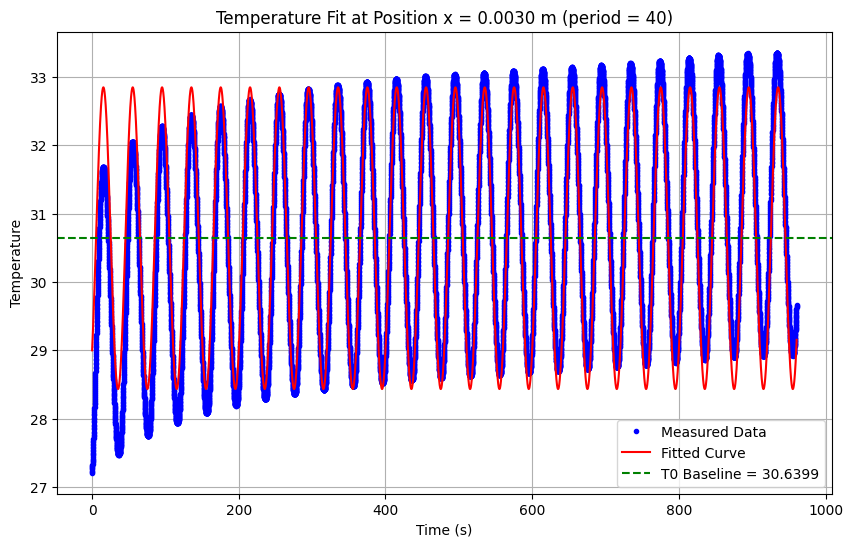


正在拟合第2个传感器（位置：0.0080m）的数据...
拟合完成 - D = 0.00003271 ± 0.00000006 m²/s, C- = 0.047750 ± 0.000213, T0 = 30.5592 ± 0.0038


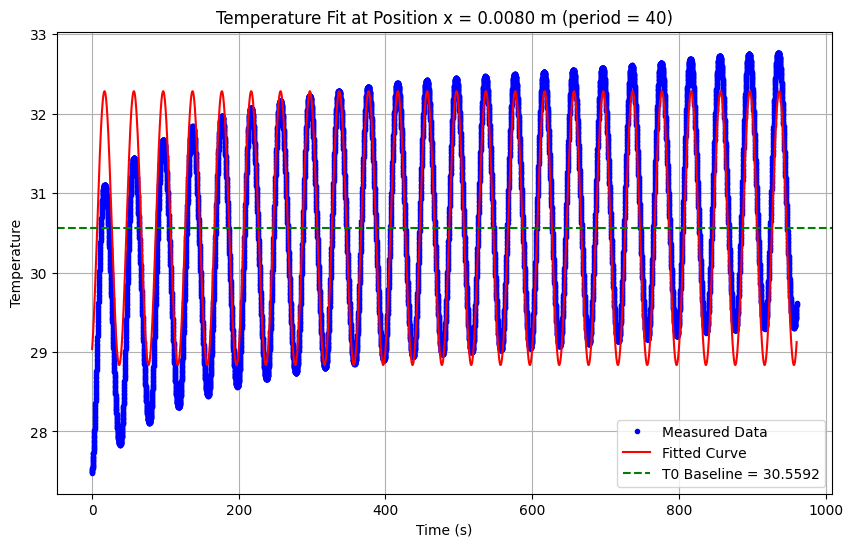


正在拟合第3个传感器（位置：0.0130m）的数据...
拟合完成 - D = 0.00003337 ± 0.00000008 m²/s, C- = 0.048828 ± 0.000279, T0 = 30.5402 ± 0.0038


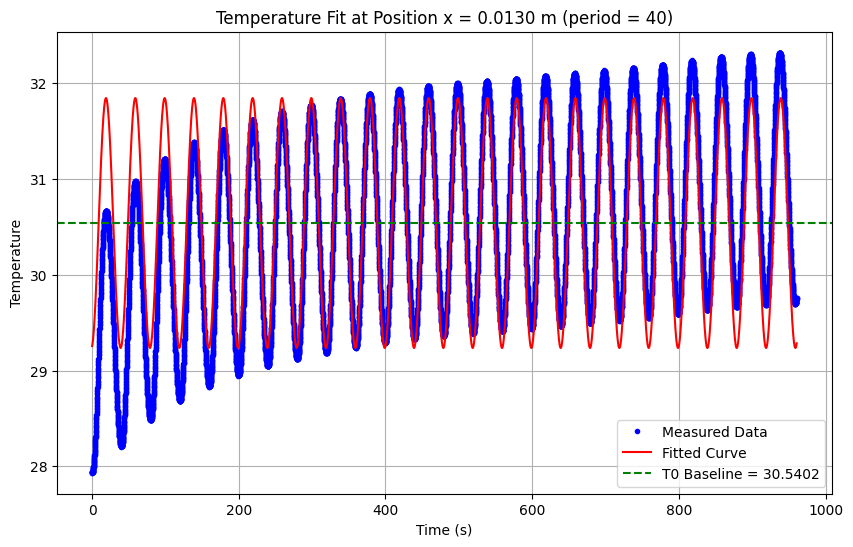


正在拟合第4个传感器（位置：0.0180m）的数据...
拟合完成 - D = 0.00003301 ± 0.00000010 m²/s, C- = 0.048200 ± 0.000337, T0 = 30.4981 ± 0.0038


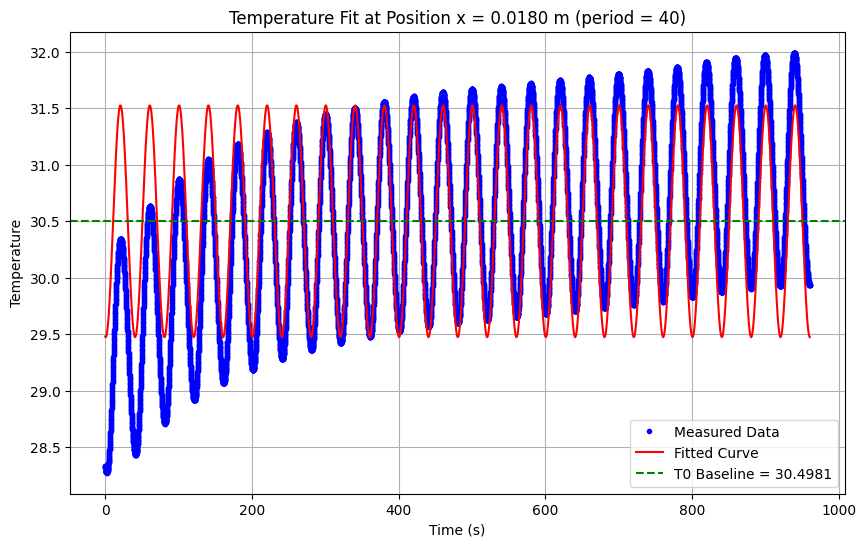


正在拟合第5个传感器（位置：0.0230m）的数据...
拟合完成 - D = 0.00003304 ± 0.00000013 m²/s, C- = 0.048574 ± 0.000395, T0 = 30.5453 ± 0.0038


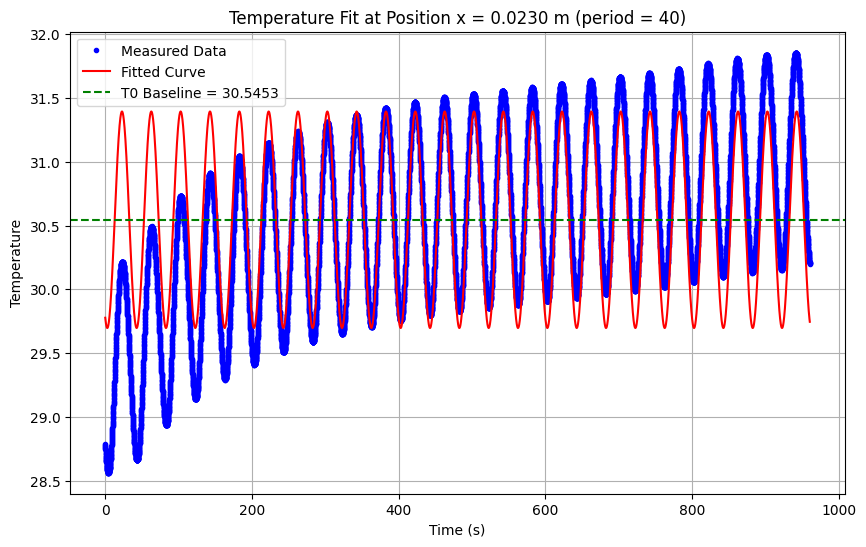


正在拟合第6个传感器（位置：0.0280m）的数据...
拟合完成 - D = 0.00003330 ± 0.00000017 m²/s, C- = 0.049066 ± 0.000447, T0 = 30.4452 ± 0.0038


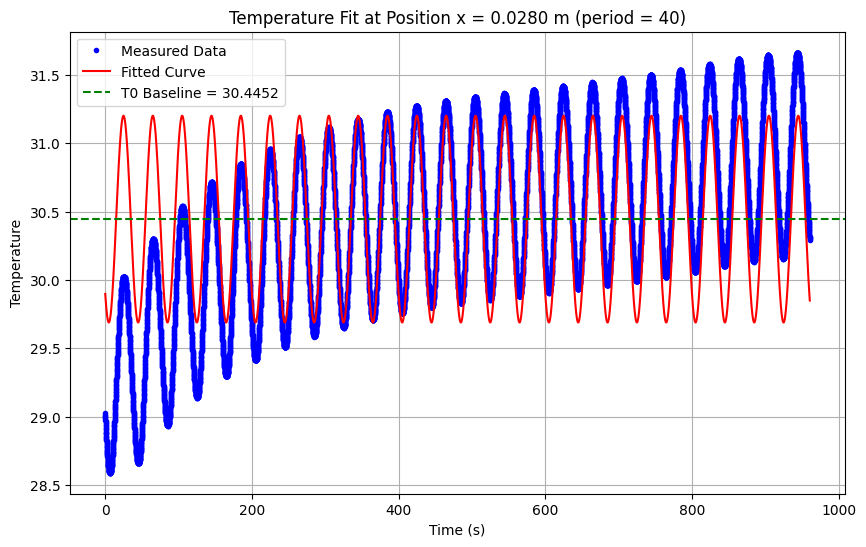


正在拟合第7个传感器（位置：0.0330m）的数据...
拟合完成 - D = 0.00003337 ± 0.00000022 m²/s, C- = 0.049208 ± 0.000487, T0 = 30.4101 ± 0.0038


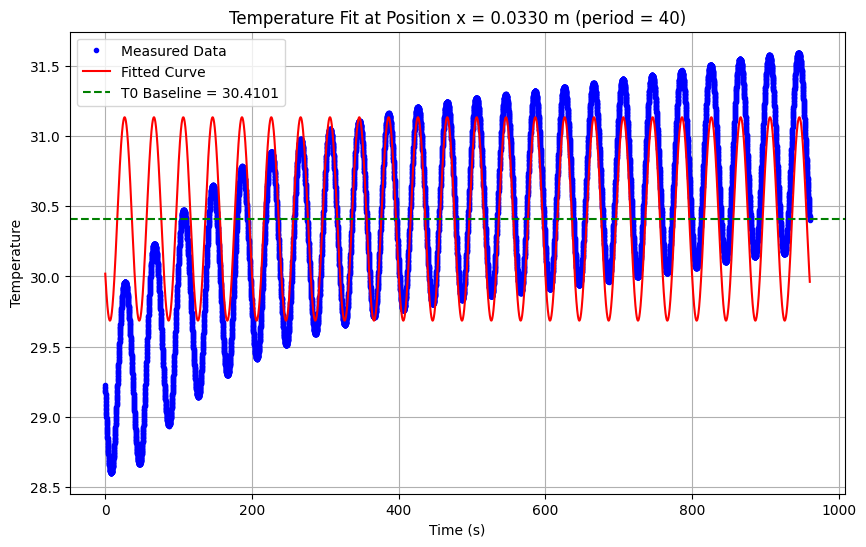


正在拟合第8个传感器（位置：0.0380m）的数据...
拟合完成 - D = 0.00003305 ± 0.00000024 m²/s, C- = 0.048772 ± 0.000510, T0 = 30.4026 ± 0.0038


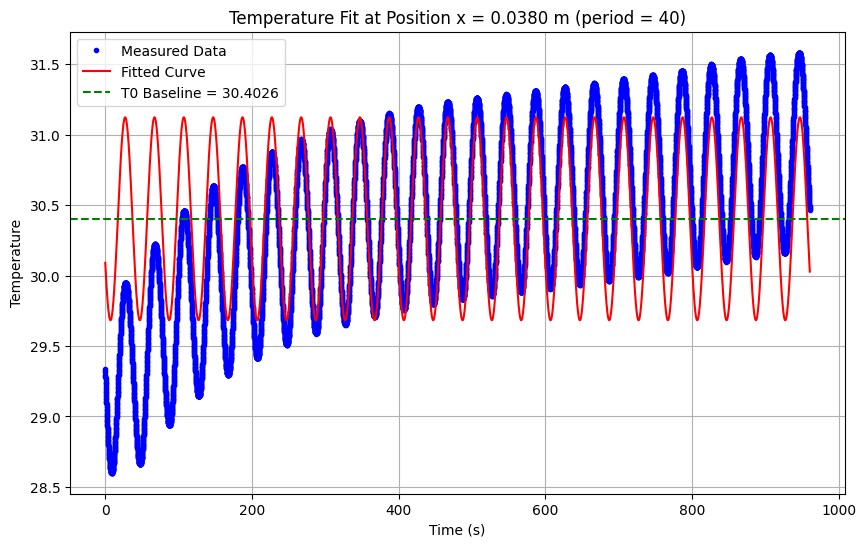


===== Fitting Results Statistics =====
D values at each position: ['0.00003288', '0.00003271', '0.00003337', '0.00003301', '0.00003304', '0.00003330', '0.00003337', '0.00003305']
Weighted average of D: 0.00003294 m²/s
T0 values at each position: ['30.6399', '30.5592', '30.5402', '30.4981', '30.5453', '30.4452', '30.4101', '30.4026']
Weighted average of T0: 30.5043


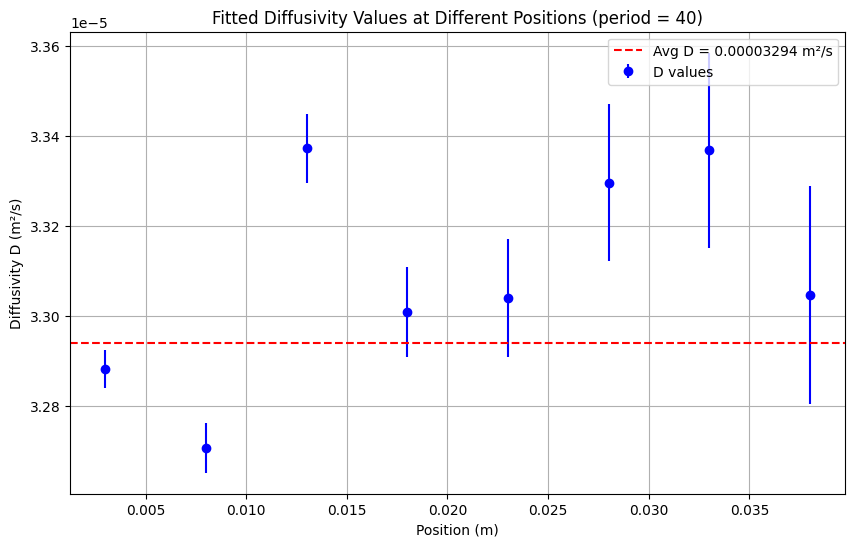


Final average diffusivity D = 0.00003294 m²/s
Final average baseline temperature T0 = 30.5043


In [90]:
if __name__ == "__main__":
    
    timestamp, output_voltage, output_current, thermistor_temperatures = (
        load_dataset("../data/brass data/brass 40s.csv")
    )
    
    # Calculate thermistor positions (in meters)
    positions = calculate_positions()
    
    # Perform fitting for D, C_minus, and T0
    results = fit_diffusivity(timestamp, thermistor_temperatures, positions)
    
    # Analyze results (get average D and T0)
    average_results = analyze_results(results)
    
    # Print final results
    if average_results:
        print(f"\nFinal average diffusivity D = {average_results['D_avg']:.8f} m²/s")
        print(f"Final average baseline temperature T0 = {average_results['T0_avg']:.4f}")